In [1]:
# load packages
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import zscore, ttest_1samp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn.glm.first_level import make_first_level_design_matrix
from tqdm import tqdm
from nilearn import datasets
import nibabel as nib
from nilearn import surface, plotting
from sklearn.decomposition import PCA

In [2]:
# set parameters
ns = 28
nc = 25
nm = 2
nv = 2
ntrait = 6
nrdm = nc*nc
nroi = 400
movies = ["physical","stutterer"]

In [3]:
# load neural RDMs
rdm = np.load("rdm_cross.npy")
rdm.shape

(28, 400, 25, 25)

In [4]:
# load online data
odat = pd.read_csv("../online-experiment/inarr-online-results.csv")
omean = odat.groupby(["movie","version","round","trait"]).ratings.mean()
omean

movie      version  round  trait        
physical   1        0      Bossy            3.666667
                           Conscientious    4.285714
                           Easygoing        3.400000
                           Humble           3.900000
                           Nosy             4.166667
                                              ...   
stutterer  2        25     Conscientious    5.833333
                           Easygoing        5.000000
                           Humble           6.777778
                           Nosy             2.833333
                           Rebellious       3.125000
Name: ratings, Length: 624, dtype: float64

In [5]:
cdatm1_v1 = omean[movies[0]][1].unstack()
cdatm2_v1 = omean[movies[1]][1].unstack()
cdatm1_v2 = omean[movies[0]][2].unstack()
cdatm2_v2 = omean[movies[1]][2].unstack()
m1u = np.zeros((nc+1,6,3))
m2u = np.zeros((nc+1,6,3))
for i in range(ntrait):
    m1 = np.mean(cdatm1_v1.iloc[:,i])
    m2 = np.mean(cdatm1_v2.iloc[:,i])
    m1c = cdatm1_v1.iloc[:,i]-m1
    m2c = cdatm1_v2.iloc[:,i]-m2
    crdat = np.vstack([m1c, m2c]).T
    pca = PCA(n_components=1)
    shared_component = pca.fit_transform(crdat)
    shared_projection = pca.inverse_transform(shared_component) 
    u1 = m1c-shared_projection[:, 0]
    u2 = m2c-shared_projection[:, 1]
    m1u[:,i,0] = u1 + m1
    m1u[:,i,1] = u2 + m2
    m1u[:,i,2] = shared_component.squeeze() + (m1+m2)/2

    m1 = np.mean(cdatm2_v1.iloc[:,i])
    m2 = np.mean(cdatm2_v2.iloc[:,i])
    m1c = cdatm2_v1.iloc[:,i]-m1
    m2c = cdatm2_v2.iloc[:,i]-m2
    crdat = np.vstack([m1c, m2c]).T
    pca = PCA(n_components=1)
    shared_component = pca.fit_transform(crdat)
    shared_projection = pca.inverse_transform(shared_component) 
    u1 = m1c-shared_projection[:, 0]
    u2 = m2c-shared_projection[:, 1]
    m2u[:,i,0] = u1 + m1
    m2u[:,i,1] = u2 + m2
    m2u[:,i,2] = shared_component.squeeze() + (m1+m2)/2

prior_trait_rdm = np.zeros((nv+1,nrdm))
post_trait_rdm = np.zeros((nv+1,nrdm))
trait_update_rdm = np.zeros((nv+1,nrdm))
for i in range(nv+1):
    prior_trait_rdm[i,:] = zscore(pairwise_distances(m1u[:-1,:,i],m2u[:-1,:,i]).flatten())
    post_trait_rdm[i,:] = zscore(pairwise_distances(m1u[1:,:,i],m2u[1:,:,i]).flatten())
    trait_update_rdm[i,:] = zscore(pairwise_distances(np.diff(m1u[:,:,i],axis=0),np.diff(m2u[:,:,i],axis=0)).flatten())

In [6]:
# determine version for each scanner participant
partv = []
for i in range(ns):
    partv.append(int(pd.read_csv("../trait-ratings/sub_" + str(i+1) + "_ratings.csv").version[0]))
partv = np.array(partv)

In [7]:
# load onset information
mtdat = pd.read_csv("../monologue_timestamps.csv")
mtdat.head()

,movie,start,stop,duration,type,clip,version_silenced
0,physical,0,148,148000,NIM,clip-0,0
1,physical,148,151,3000,IM,clip-1,2
2,physical,151,177,26000,NIM,clip-2,0
3,physical,177,188,11000,IM,clip-3,1
4,physical,188,245,57000,NIM,clip-4,0


In [8]:
# create selectors for segment type
sel = np.zeros((25))
sel[np.arange(0,25,2)]=1
sel = pairwise_distances(sel.reshape(-1,1))
nimsel = sel==1
nimsel = nimsel.flatten()
imsel = sel==0
imsel = imsel.flatten()

In [9]:
# perform RSA
nreg = 3
ncond = 2
condsel = [nimsel,imsel]
coefs = np.zeros((ns,nroi,nreg,ncond))
for i in range(ncond):
    for j in tqdm(range(ns)):       
        for k in range(nroi):
            y = rdm[j,k,:].flatten()
            X = np.vstack((trait_update_rdm[partv[j]-1,:],trait_update_rdm[2-partv[j],:],trait_update_rdm[2,:])).T
            coefs[j,k,:,i] = LinearRegression().fit(X[condsel[i],:], y[condsel[i]]).coef_

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.08it/s]


In [10]:
# permutation testing
nperm = 10000
ptmat = np.zeros((3,2,nroi,nperm))
np.random.seed(0)
for i in tqdm(range(nperm)):
    psel = np.random.choice((-1,1),ns,True)
    psel = psel.reshape(-1, 1, 1, 1)
    pcoefs = coefs*psel
    ptmat[0,0,:,i] = ttest_1samp(pcoefs[:,:,2,0],0,axis=0)[0]
    ptmat[0,1,:,i] = ttest_1samp(pcoefs[:,:,2,1],0,axis=0)[0]
    ptmat[1,0,:,i] = ttest_1samp(pcoefs[:,:,0,0],0,axis=0)[0]
    ptmat[1,1,:,i] = ttest_1samp(pcoefs[:,:,0,1],0,axis=0)[0]
    ptmat[2,0,:,i] = ttest_1samp(pcoefs[:,:,0,0]-pcoefs[:,:,1,0],0,axis=0)[0]
    ptmat[2,1,:,i] = ttest_1samp(pcoefs[:,:,0,1]-pcoefs[:,:,1,1],0,axis=0)[0]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 140.46it/s]


In [11]:
# compare true test statistics to permuted versions
pth = .05

# compute true test statistics
tmat = np.zeros((3,2,nroi))
tmat[0,0,:] = ttest_1samp(coefs[:,:,2,0],0,axis=0)[0]
tmat[0,1,:] = ttest_1samp(coefs[:,:,2,1],0,axis=0)[0]
tmat[1,0,:] = ttest_1samp(coefs[:,:,0,0],0,axis=0)[0]
tmat[1,1,:] = ttest_1samp(coefs[:,:,0,1],0,axis=0)[0]
tmat[2,0,:] = ttest_1samp(coefs[:,:,0,0]-coefs[:,:,1,0],0,axis=0)[0]
tmat[2,1,:] = ttest_1samp(coefs[:,:,0,1]-coefs[:,:,1,1],0,axis=0)[0]

# compute maximal distribution
mxt = np.max(np.abs(ptmat),axis=2)
pcorrmat = np.zeros((3,2,nroi))
for i in range(3):
    for j in range(2):
        for m in range(nroi):
            pcorrmat[i,j,m] = np.mean(mxt[i,j,:]>=np.abs(tmat[i,j,m]))


print(np.mean(pcorrmat[0,0,:]<pth))
print(np.mean(pcorrmat[0,1,:]<pth))
print(" ")
print(np.mean(pcorrmat[1,0,:]<pth))
print(np.mean(pcorrmat[1,1,:]<pth))
print(" ")
print(np.mean(pcorrmat[2,0,:]<pth))
print(np.mean(pcorrmat[2,1,:]<pth))
print(" ")

0.0325
0.0
 
0.01
0.0
 
0.0075
0.0
 


In [12]:
# retrieve the atlas
nreg = 400
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=nreg, yeo_networks=17, resolution_mm=2)
atlas_filename = atlas['maps']
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

[fetch_atlas_schaefer_2018] Dataset found in C:\Users\mthor\nilearn_data\schaefer_2018


In [13]:
# write out significance masks and t-statistics
outdir1 = "./crossmovie-rsa/sigmasks/"
outdir2 = "./crossmovie-rsa/results/"
d1 = ["shared","matched","difference"]
d2 = ["NIM","IM"]
for i in range(3):
    for j in range(2):
        fname = "update_" + d1[i] + "_" + d2[j] + "_" + ".nii.gz"
            
        mapped_data = np.zeros_like(atlas_data)
        mapped_data[atlas_data == 0] = np.nan
        for m in range(1,nreg+1):       
            mapped_data[atlas_data == m] = pcorrmat[i,j,m-1]<pth
        new_img = nib.Nifti1Image(mapped_data, affine=atlas_img.affine)
        nib.save(new_img, outdir1 + fname)

        mapped_data = np.zeros_like(atlas_data)
        mapped_data[atlas_data == 0] = np.nan
        for m in range(1,nreg+1):       
            mapped_data[atlas_data == m] = tmat[i,j,m-1]
        new_img = nib.Nifti1Image(mapped_data, affine=atlas_img.affine)
        nib.save(new_img, outdir2 + fname)



[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3792825271.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3792825271.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3792825271.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3792825271.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3792825271.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3792825271.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


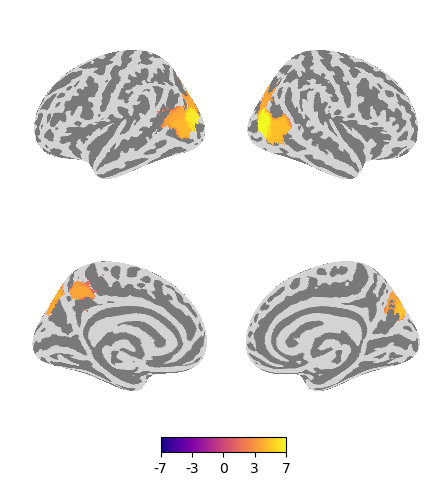

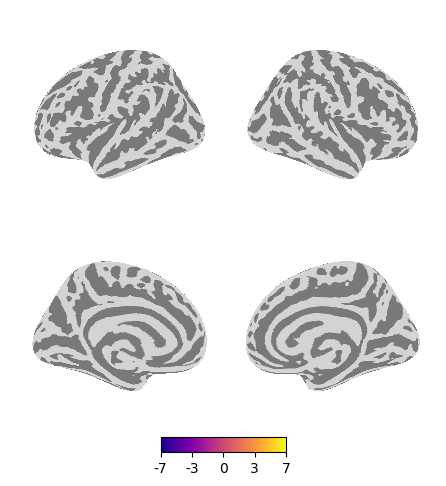

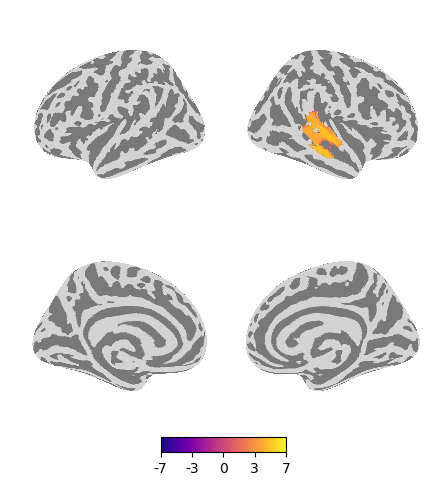

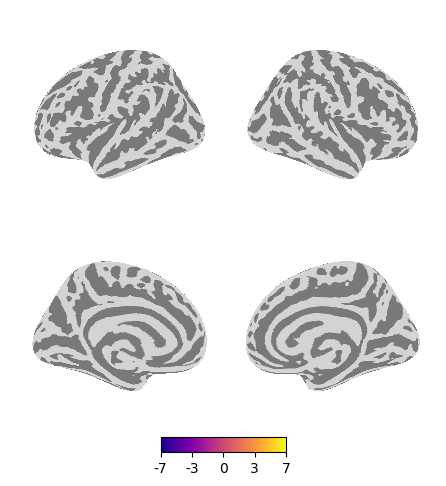

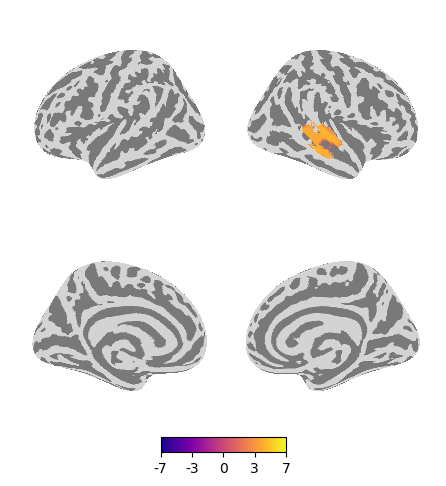

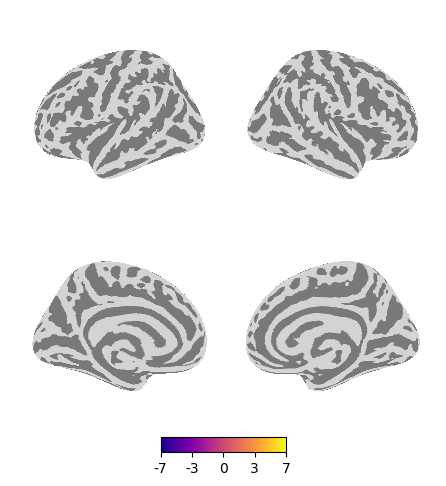

In [14]:
for i in range(3):
    for j in range(2):
        fname = "update_" + d1[i] + "_" + d2[j] + "_"
        display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,
                                views=['lateral', 'medial'],vmax=7.5,vmin=-7.5,
                                mask_img="./crossmovie-rsa/sigmasks/" + fname + ".nii.gz",
                                hemispheres=['left', 'right'],
                                colorbar=True,cmap="plasma")
        display[0].savefig("./crossmovie-rsa/jpg/" + fname + ".jpg", dpi=600)

In [15]:
# perform RSA
nreg = 3
ncond = 2
condsel = [nimsel,imsel]
coefs = np.zeros((ns,nroi,nreg,ncond))
for i in range(ncond):
    for j in tqdm(range(ns)):       
        for k in range(nroi):
            y = rdm[j,k,:].flatten()
            X = np.vstack((prior_trait_rdm[partv[j]-1,:],prior_trait_rdm[2-partv[j],:],prior_trait_rdm[2,:])).T
            coefs[j,k,:,i] = LinearRegression().fit(X[condsel[i],:], y[condsel[i]]).coef_

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.96it/s]


In [16]:
# permutation testing
nperm = 10000
ptmat = np.zeros((3,2,nroi,nperm))
np.random.seed(0)
for i in tqdm(range(nperm)):
    psel = np.random.choice((-1,1),ns,True)
    psel = psel.reshape(-1, 1, 1, 1)
    pcoefs = coefs*psel
    ptmat[0,0,:,i] = ttest_1samp(pcoefs[:,:,2,0],0,axis=0)[0]
    ptmat[0,1,:,i] = ttest_1samp(pcoefs[:,:,2,1],0,axis=0)[0]
    ptmat[1,0,:,i] = ttest_1samp(pcoefs[:,:,0,0],0,axis=0)[0]
    ptmat[1,1,:,i] = ttest_1samp(pcoefs[:,:,0,1],0,axis=0)[0]
    ptmat[2,0,:,i] = ttest_1samp(pcoefs[:,:,0,0]-pcoefs[:,:,1,0],0,axis=0)[0]
    ptmat[2,1,:,i] = ttest_1samp(pcoefs[:,:,0,1]-pcoefs[:,:,1,1],0,axis=0)[0]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:30<00:00, 66.61it/s]


In [17]:
# compare true test statistics to permuted versions
pth = .05

# compute true test statistics
tmat = np.zeros((3,2,nroi))
tmat[0,0,:] = ttest_1samp(coefs[:,:,2,0],0,axis=0)[0]
tmat[0,1,:] = ttest_1samp(coefs[:,:,2,1],0,axis=0)[0]
tmat[1,0,:] = ttest_1samp(coefs[:,:,0,0],0,axis=0)[0]
tmat[1,1,:] = ttest_1samp(coefs[:,:,0,1],0,axis=0)[0]
tmat[2,0,:] = ttest_1samp(coefs[:,:,0,0]-coefs[:,:,1,0],0,axis=0)[0]
tmat[2,1,:] = ttest_1samp(coefs[:,:,0,1]-coefs[:,:,1,1],0,axis=0)[0]

# compute maximal distribution
mxt = np.max(np.abs(ptmat),axis=2)
pcorrmat = np.zeros((3,2,nroi))
for i in range(3):
    for j in range(2):
        for m in range(nroi):
            pcorrmat[i,j,m] = np.mean(mxt[i,j,:]>=np.abs(tmat[i,j,m]))


print(np.mean(pcorrmat[0,0,:]<pth))
print(np.mean(pcorrmat[0,1,:]<pth))
print(" ")
print(np.mean(pcorrmat[1,0,:]<pth))
print(np.mean(pcorrmat[1,1,:]<pth))
print(" ")
print(np.mean(pcorrmat[2,0,:]<pth))
print(np.mean(pcorrmat[2,1,:]<pth))
print(" ")

0.0025
0.0
 
0.03
0.025
 
0.0
0.0
 


In [18]:
# retrieve the atlas
nreg = 400
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=nreg, yeo_networks=17, resolution_mm=2)
atlas_filename = atlas['maps']
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

[fetch_atlas_schaefer_2018] Dataset found in C:\Users\mthor\nilearn_data\schaefer_2018


In [19]:
# write out significance masks and t-statistics
outdir1 = "./crossmovie-rsa/sigmasks/"
outdir2 = "./crossmovie-rsa/results/"
d1 = ["shared","matched","difference"]
d2 = ["NIM","IM"]
for i in range(3):
    for j in range(2):
        fname = "prior_" + d1[i] + "_" + d2[j] + "_" + ".nii.gz"
            
        mapped_data = np.zeros_like(atlas_data)
        mapped_data[atlas_data == 0] = np.nan
        for m in range(1,nreg+1):       
            mapped_data[atlas_data == m] = pcorrmat[i,j,m-1]<pth
        new_img = nib.Nifti1Image(mapped_data, affine=atlas_img.affine)
        nib.save(new_img, outdir1 + fname)

        mapped_data = np.zeros_like(atlas_data)
        mapped_data[atlas_data == 0] = np.nan
        for m in range(1,nreg+1):       
            mapped_data[atlas_data == m] = tmat[i,j,m-1]
        new_img = nib.Nifti1Image(mapped_data, affine=atlas_img.affine)
        nib.save(new_img, outdir2 + fname)



[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3984303230.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3984303230.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3984303230.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3984303230.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3984303230.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


[plot_img_on_surf] Dataset found in C:\Users\mthor\nilearn_data\fsaverage


C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\surface\surface.py:604: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:122: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
C:\Users\mthor\miniconda3\envs\fdr\lib\site-packages\nilearn\plotting\_utils.py:125: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
C:\Users\mthor\AppData\Local\Temp\ipykernel_32308\3984303230.py:4: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,


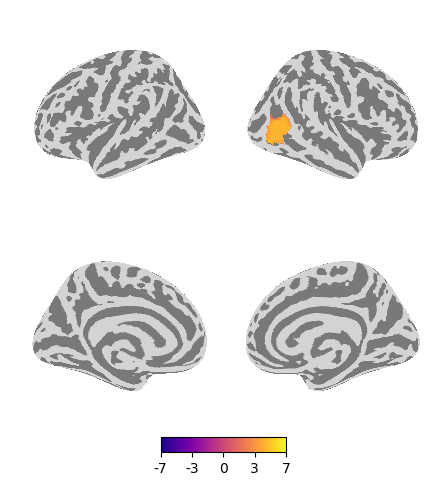

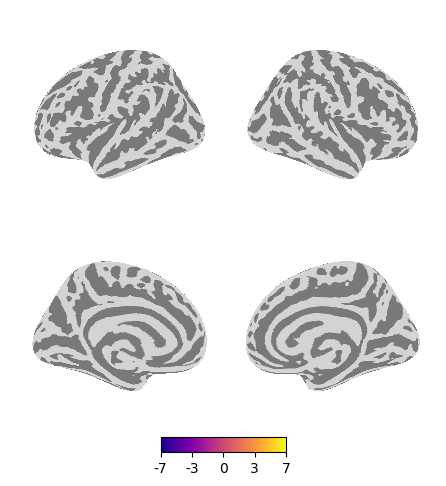

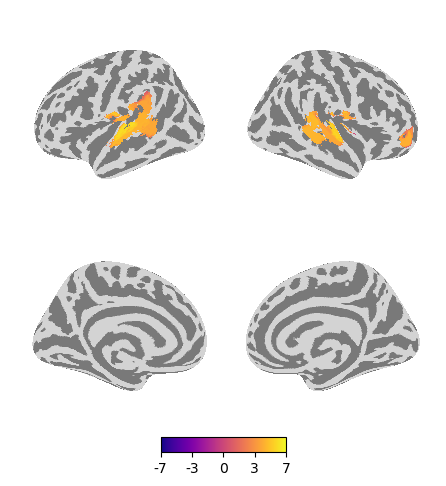

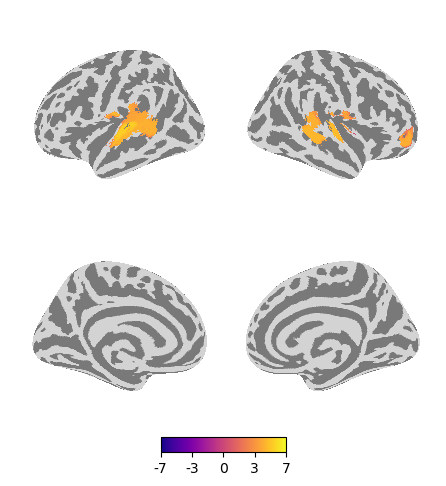

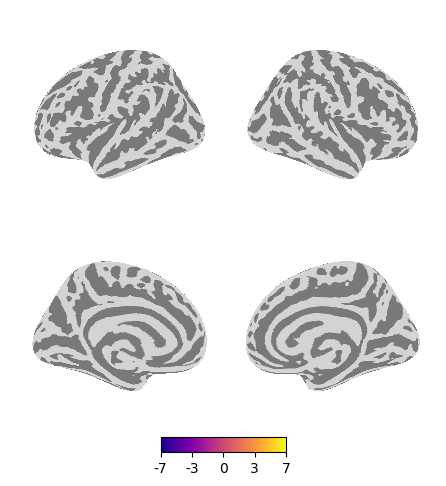

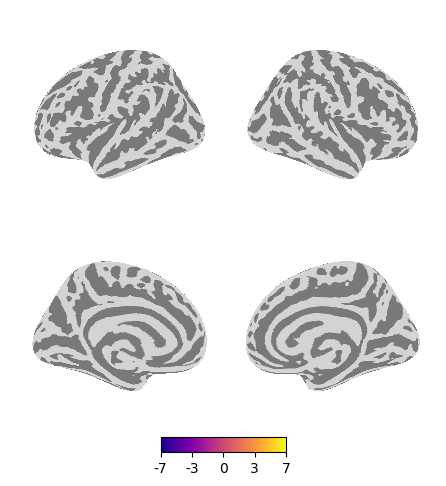

In [20]:
for i in range(3):
    for j in range(2):
        fname = "prior_" + d1[i] + "_" + d2[j] + "_"
        display = plotting.plot_img_on_surf("./crossmovie-rsa/results/" + fname + ".nii.gz","fsaverage",inflate=True,
                                views=['lateral', 'medial'],vmax=7.5,vmin=-7.5,
                                mask_img="./crossmovie-rsa/sigmasks/" + fname + ".nii.gz",
                                hemispheres=['left', 'right'],
                                colorbar=True,cmap="plasma")
        display[0].savefig("./crossmovie-rsa/jpg/" + fname + ".jpg", dpi=600)